**Forecasting (Coco Cola Sales)**

In [342]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

**Loading and Analysing data by line plot**

In [343]:
data=pd.read_excel('/content/CocaCola_Sales_Rawdata.xlsx')
data.head(12)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [344]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


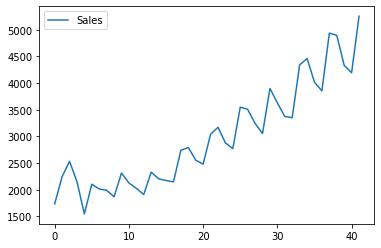

In [345]:
data.plot();
pyplot.show()

**We can see there is increasing trend and we can also say there is seasonality as well.**

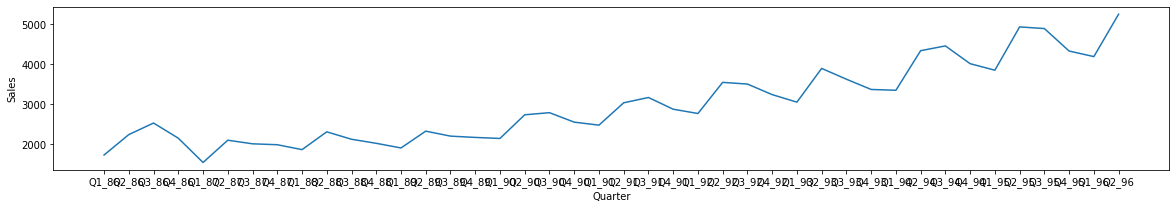

In [346]:
#Line plot
plt.figure(figsize=(20,3))
sns.lineplot(x="Quarter",y="Sales",data=data);

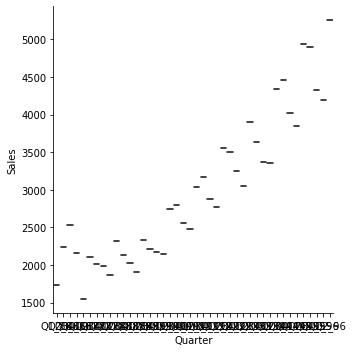

In [347]:
sns.factorplot("Quarter","Sales",data=data,kind="box");

**Data Pre Processing**

In [348]:
quarter=['Q1','Q2','Q3','Q4']
n=data['Quarter'][0]
n[0:2]

data['quarter']=0

In [349]:
for i in range(42):
    n=data['Quarter'][i]
    data['quarter'][i]=n[0:2]

In [350]:
dummy=pd.DataFrame(pd.get_dummies(data['quarter']))
dummy.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [351]:
# adding t and t_square columns to dataset
coco=pd.concat((data,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

In [352]:
coco.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_square
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25


In [353]:
# Adding log_sales to dataset
log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales
coco.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_square,log_Sales
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602


In [354]:
# Splitting data to train and test (validation)

In [355]:
Train= coco.head(37)
Test=coco.tail(5)

**Model Based Approch (Buliding Models)**

In [356]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

737.1568992951951

In [357]:
#Exponential

Exp = smf.ols('log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

586.8646090003102

In [358]:
#Quadratic 

Quad = smf.ols('Sales~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

445.8029895177927

In [359]:
#Additive seasonality 

add_sea = smf.ols('Sales~ Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1931.36279040632

In [360]:
#Additive Seasonality with Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

252.2557608176047

In [361]:
#additive seasonality with linear trend
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=Train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(Test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

rmse_add_linear=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(predaddlinear))**2))
rmse_add_linear

572.3530370243457

In [362]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_Sales~Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(pd.DataFrame(Test[['Q1','Q2','Q3','Q4']])))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

2023.7328645103598

In [363]:
#multiplicative seasonality with linear trend
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=Train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(Test[['t','Q1','Q2','Q3','Q4']])))
rmse_mu_lin=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(predmullin)))**2))
rmse_mu_lin

290.26847888864995

In [364]:
#multiplicative seasonality with quadratic trend
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=Train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(Test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

594.3833855598255

In [365]:
# Tabulating Models with their RMSE values
Models = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad",'rmse_add_linear',"rmse_Mult_sea",'rmse_mu_lin',"rmse_mul_quad"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_add_linear,rmse_Mult_sea,rmse_mu_lin,rmse_mul_quad])}
table_rmse=pd.DataFrame(Models)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,252.255761
7,rmse_mu_lin,290.268479
2,rmse_Quad,445.802990
5,rmse_add_linear,572.353037
1,rmse_Exp,586.864609
8,rmse_mul_quad,594.383386
0,rmse_linear,737.156899
3,rmse_add_sea,1931.362790
6,rmse_Mult_sea,2023.732865


**Data Driven Models**

In [366]:
#Moving Average

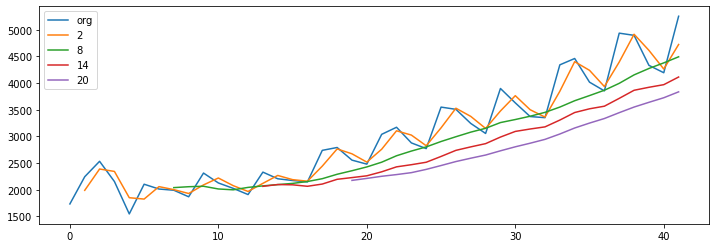

In [367]:
plt.figure(figsize=(12,4))
coco.Sales.plot(label="org")
for i in range(2,24,6):
    coco["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [368]:
# ACF plots and PACF plots

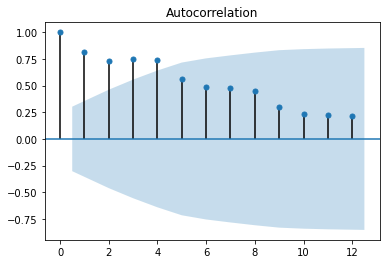

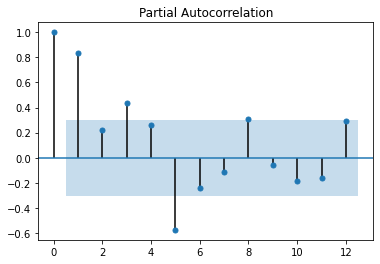

In [369]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(coco.Sales,lags=12)
tsa_plots.plot_pacf(coco.Sales,lags=12)
plt.show()

In [370]:
# MAPE 
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [371]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(Train['Sales']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) 

19.12727544457338

In [372]:
# Holt method 
hw_model = Holt(Train['Sales']).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 

14.286062827267376

In [373]:
#Holts winter exponential smoothing with additive seasonality and additive trend

hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) 

4.2521831635724165

In [374]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend

hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

3.639952023932765

In [375]:
# Final Modelbuilding with train+test data

In [376]:
hwe_model_mul_add_final = ExponentialSmoothing(coco["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 

In [377]:
#Forecasting for next 10 time periods
hwe_model_mul_add_final.forecast(15)

42    4923.825834
43    4585.806901
44    4530.662095
45    5759.370929
46    5819.152426
47    5203.721006
48    4956.155622
49    6256.502400
50    6107.476878
51    5463.902671
52    5266.754892
53    6577.688511
54    6134.418921
55    5690.656273
56    5600.741202
dtype: float64

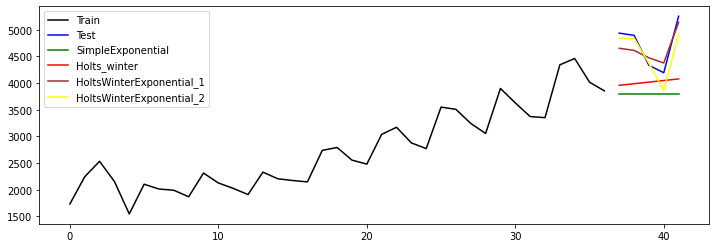

In [378]:
# Visualization of Forecasted values for Test data set using different methods 
plt.figure(figsize=(12,4))
plt.plot(Train.index, Train["Sales"], label='Train',color="black")
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best');

In [379]:
# ARIMA model

In [380]:
from statsmodels.tsa.arima_model import ARIMA

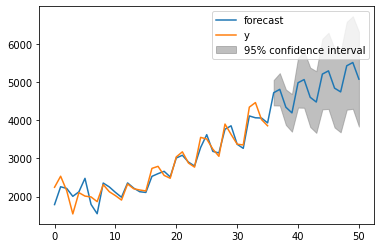

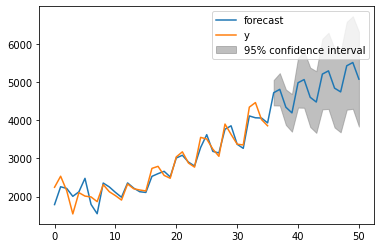

In [381]:
X = Train.Sales.values
X = X.astype('float32')
model = ARIMA(X, order=(4,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 51)

In [382]:
# Error with test data
from sklearn.metrics import mean_squared_error
from math import sqrt
y=Test.Sales.values
y=y.astype('float32')
rmse = sqrt(mean_squared_error(y, forecast[0:5]))
rmse

160.66302135821942

In [383]:
forecast

array([4719.32796755, 4807.25367626, 4340.27689638, 4191.52093352,
       4980.31383204, 5063.21109303, 4599.17314297, 4475.55074522,
       5206.76245535, 5290.77987519])

ARIMA model has better RMSE value than Model Based Approaches

**SARIMA MODEL**

In [384]:
ts = data['Sales']
ts.tail()

37    4936.0
38    4895.0
39    4333.0
40    4194.0
41    5253.0
Name: Sales, dtype: float64

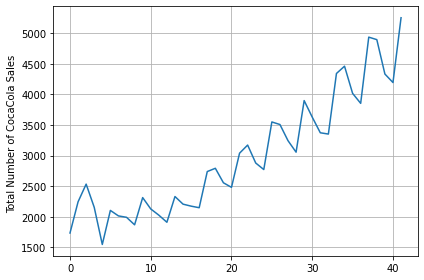

In [385]:
import matplotlib.pylab as plt
plt.plot(ts)
plt.ylabel('Total Number of CocaCola Sales ')
plt.grid()
plt.tight_layout()
plt.savefig('CocaCola_Sales_Rawdata.png')
plt.show()

In [386]:
from statsmodels.tsa.stattools import adfuller

def CocaCola_Sales(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non Sales
        print("X is Sales")
        return True
    else:
        print("X is not Sales")
        return False

In [387]:
ts_diff = pd.Series(ts)
d = 0
while CocaCola_Sales(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1

X is not Sales
X is not Sales
X is Sales


**Build the SARIMA model**

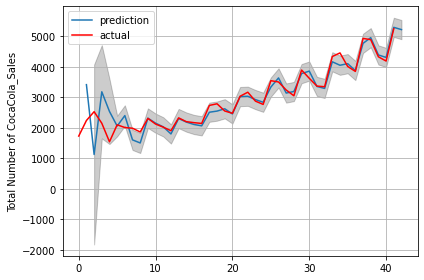

In [388]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 9
q = 1
model = SARIMAX(ts, order=(p,d,q))
model_fit = model.fit(disp=1,solver='powell')
    
fcast = model_fit.get_prediction(start=1, end=len(ts))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()


plt.show()
plt.plot(ts_p,label='prediction')
plt.plot(ts,color='red',label='actual')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2)

plt.ylabel('Total Number of CocaCola_Sales')
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig('CocaCola_Sales.png')
plt.show()

**Calculate some statistics**

In [389]:
from scipy import stats
stats.pearsonr(ts_p[1:], ts[1:]) 

(0.9066358213154487, 3.370247744487896e-16)

In [390]:
residuals = ts - ts_p
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ts-np.mean(ts))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.8365517301987948